In [1]:
import pickle
from pathlib import Path

import cv2
import joblib
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
import torch
from segment_anything import SamAutomaticMaskGenerator, SamPredictor, sam_model_registry

SAM_MODEL_DIR = Path("../sa_models")

In [2]:
img_path = Path(
    "/tf/notebooks/gotmeals/EDA/FoodSeg103/Images/img_dir/test/00000048.jpg"
)
if img_path.exists():
    img = Image.open(img_path)
    img = np.asarray(img)
    print(f"Image shape: {img.shape}")
else:
    print(f"File not found {img_path}")

Image shape: (485, 512, 3)


In [3]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x["area"]), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones(
        (
            sorted_anns[0]["segmentation"].shape[0],
            sorted_anns[0]["segmentation"].shape[1],
            4,
        )
    )
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann["segmentation"]
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [4]:
# class SamAutomaticMaskGenerator:
#     def __init__(
#         self,
#         model: Sam,
#         points_per_side: Optional[int] = 32,
#         points_per_batch: int = 64,
#         pred_iou_thresh: float = 0.88,
#         stability_score_thresh: float = 0.95,
#         stability_score_offset: float = 1.0,
#         box_nms_thresh: float = 0.7,
#         crop_n_layers: int = 0,
#         crop_nms_thresh: float = 0.7,
#         crop_overlap_ratio: float = 512 / 1500,
#         crop_n_points_downscale_factor: int = 1,
#         point_grids: Optional[List[np.ndarray]] = None,
#         min_mask_region_area: int = 0,
#         output_mode: str = "binary_mask",
#     ) -> None:
#         """
#         Using a SAM model, generates masks for the entire image.
#         Generates a grid of point prompts over the image, then filters
#         low quality and duplicate masks. The default settings are chosen
#         for SAM with a ViT-H backbone.

#         Arguments:
#           model (Sam): The SAM model to use for mask prediction.
#           points_per_side (int or None): The number of points to be sampled
#             along one side of the image. The total number of points is
#             points_per_side**2. If None, 'point_grids' must provide explicit
#             point sampling.
#           points_per_batch (int): Sets the number of points run simultaneously
#             by the model. Higher numbers may be faster but use more GPU memory.
#           pred_iou_thresh (float): A filtering threshold in [0,1], using the
#             model's predicted mask quality.
#           stability_score_thresh (float): A filtering threshold in [0,1], using
#             the stability of the mask under changes to the cutoff used to binarize
#             the model's mask predictions.
#           stability_score_offset (float): The amount to shift the cutoff when
#             calculated the stability score.
#           box_nms_thresh (float): The box IoU cutoff used by non-maximal
#             suppression to filter duplicate masks.
#           crop_n_layers (int): If >0, mask prediction will be run again on
#             crops of the image. Sets the number of layers to run, where each
#             layer has 2**i_layer number of image crops.
#           crop_nms_thresh (float): The box IoU cutoff used by non-maximal
#             suppression to filter duplicate masks between different crops.
#           crop_overlap_ratio (float): Sets the degree to which crops overlap.
#             In the first crop layer, crops will overlap by this fraction of
#             the image length. Later layers with more crops scale down this overlap.
#           crop_n_points_downscale_factor (int): The number of points-per-side
#             sampled in layer n is scaled down by crop_n_points_downscale_factor**n.
#           point_grids (list(np.ndarray) or None): A list over explicit grids
#             of points used for sampling, normalized to [0,1]. The nth grid in the
#             list is used in the nth crop layer. Exclusive with points_per_side.
#           min_mask_region_area (int): If >0, postprocessing will be applied
#             to remove disconnected regions and holes in masks with area smaller
#             than min_mask_region_area. Requires opencv.
#           output_mode (str): The form masks are returned in. Can be 'binary_mask',
#             'uncompressed_rle', or 'coco_rle'. 'coco_rle' requires pycocotools.
#             For large resolutions, 'binary_mask' may consume large amounts of
#             memory.
#         """

In [38]:
sam_checkpoint = SAM_MODEL_DIR.joinpath("sam_vit_h_4b8939.pth")
if not sam_checkpoint.exists():
    print(f"File not found {sam_checkpoint}")
model_type = "vit_h"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
sam_model = sam_model_registry[model_type](sam_checkpoint)
sam_model.to(device=device)
mask_generator = SamAutomaticMaskGenerator(
    sam_model,
    points_per_side=10,
    box_nms_thresh=0.2,
    min_mask_region_area=100,
    crop_n_layers=1,
    points_per_batch=128,
)
masks = mask_generator.generate(img)
print(f"Number of segments found: {len(masks)}")

Using device: cuda
Number of segments found: 76


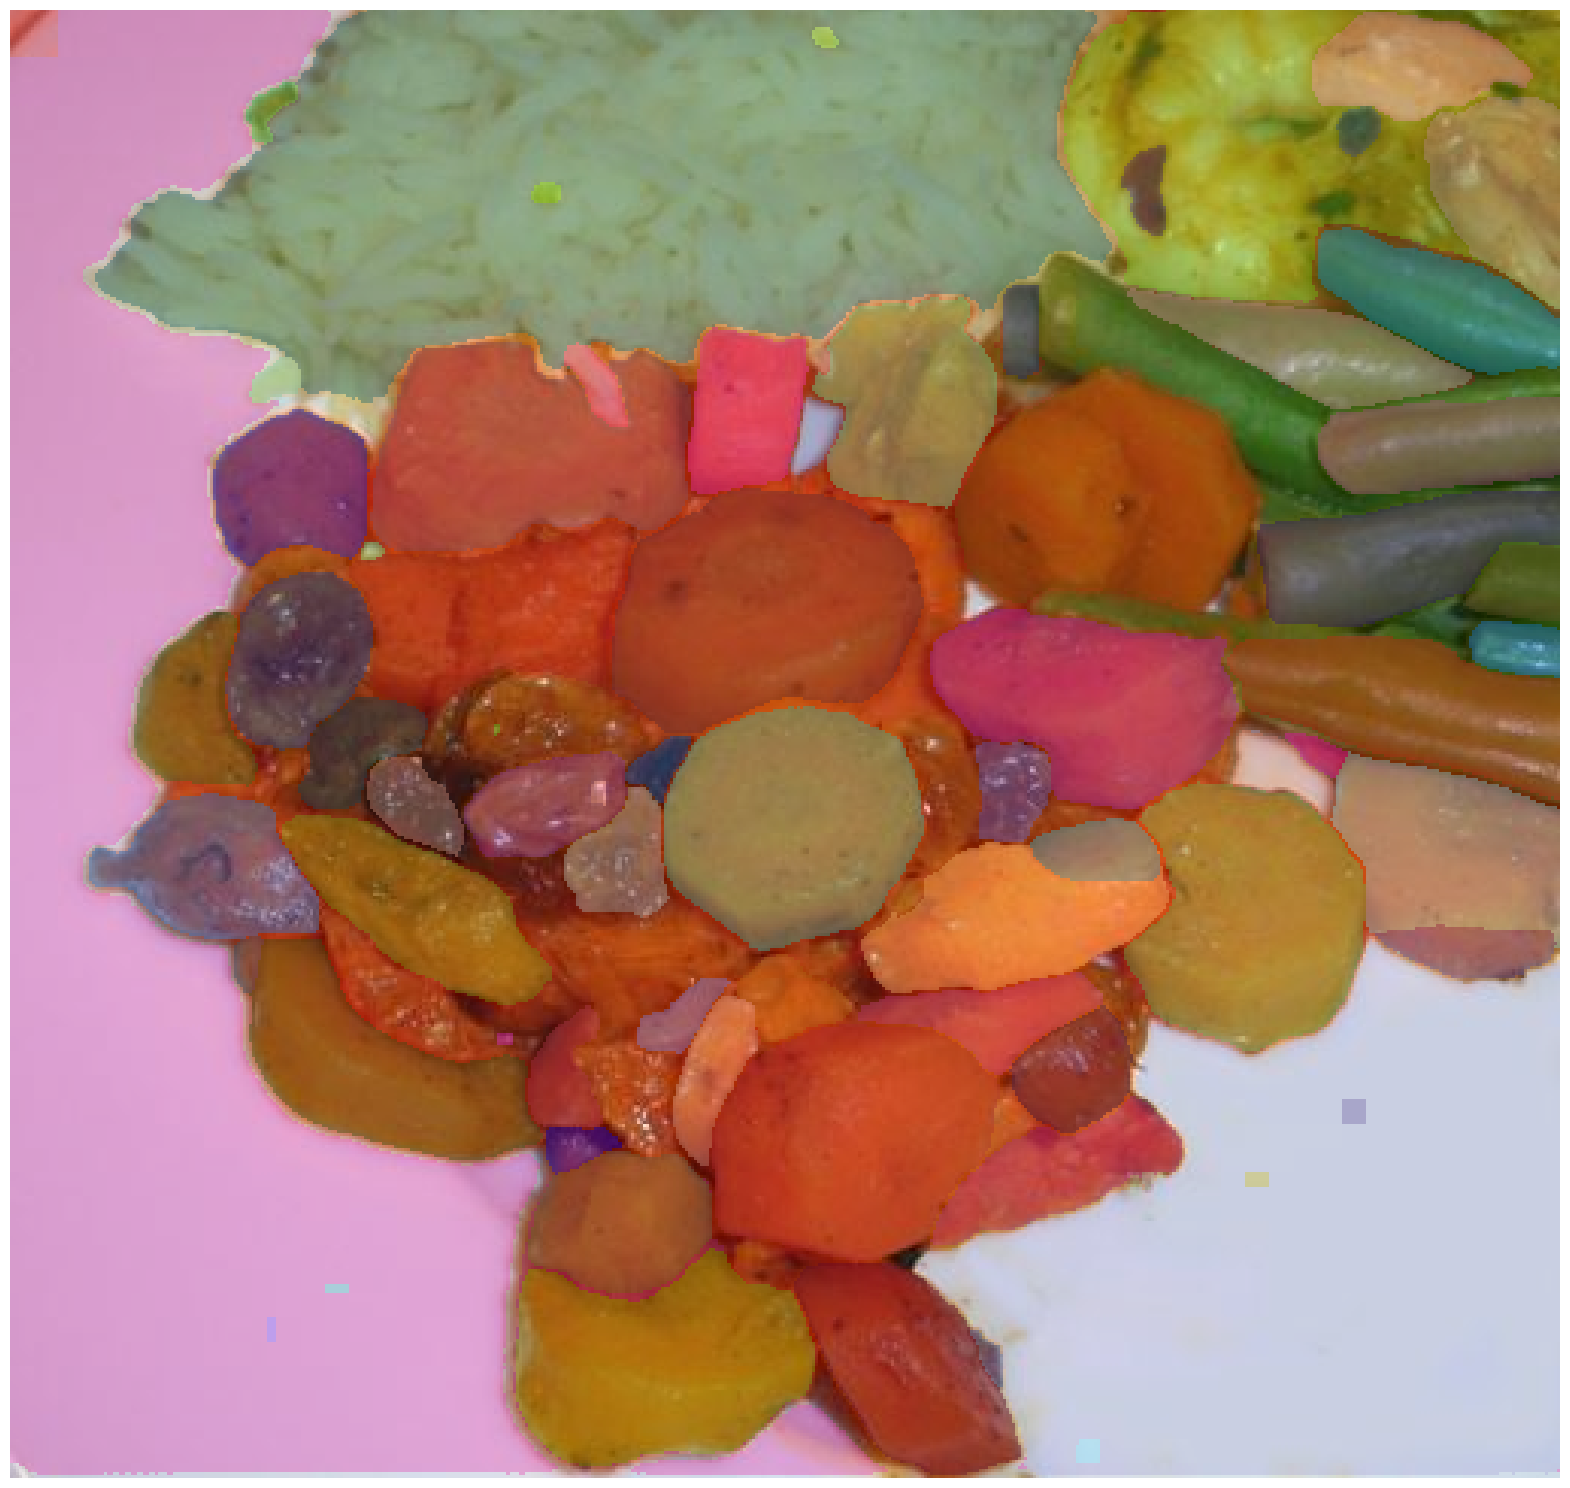

In [39]:
plt.figure(figsize=(20, 20))
plt.imshow(img)
show_anns(masks)
plt.axis("off")
plt.show()

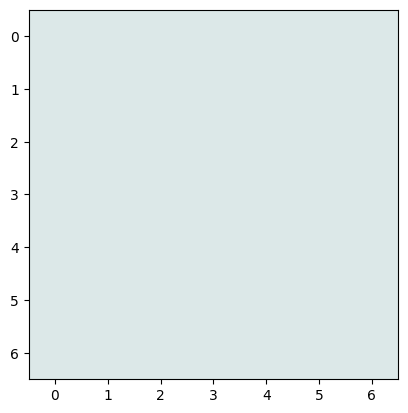

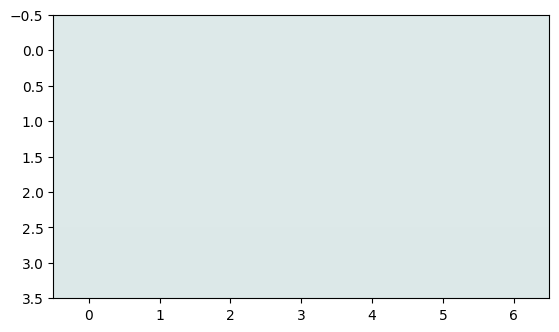

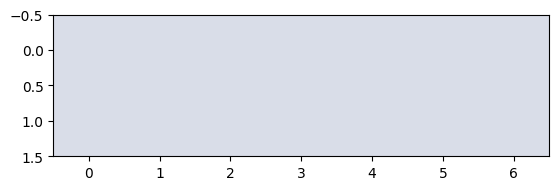

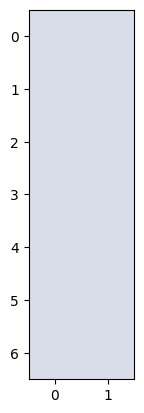

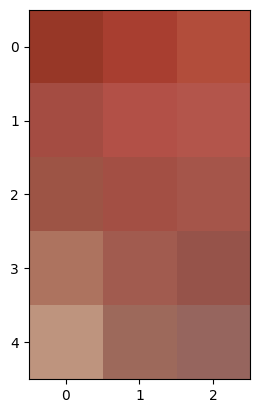

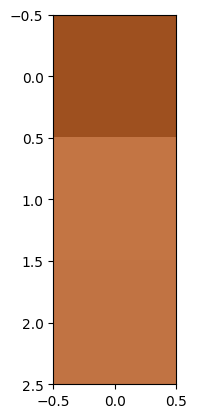

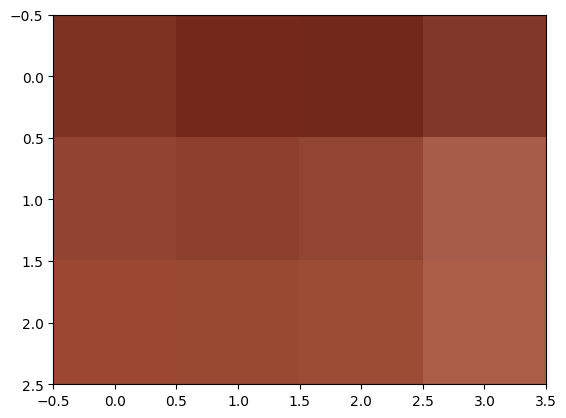

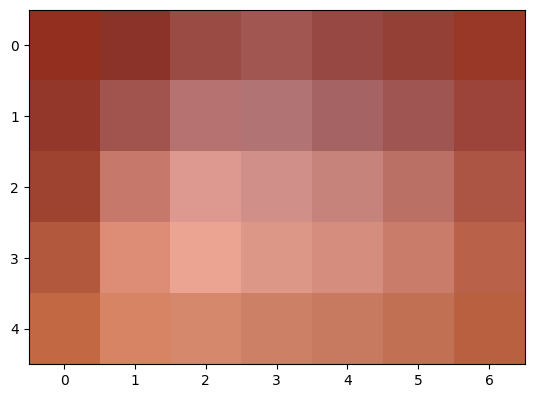

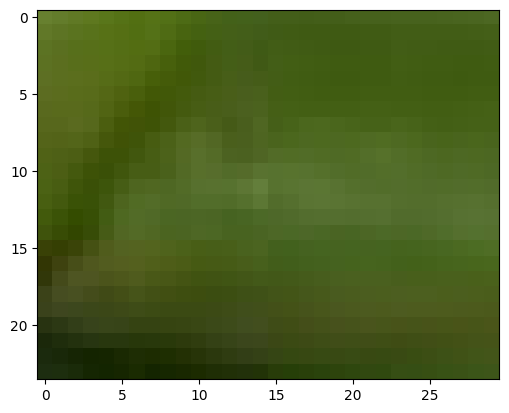

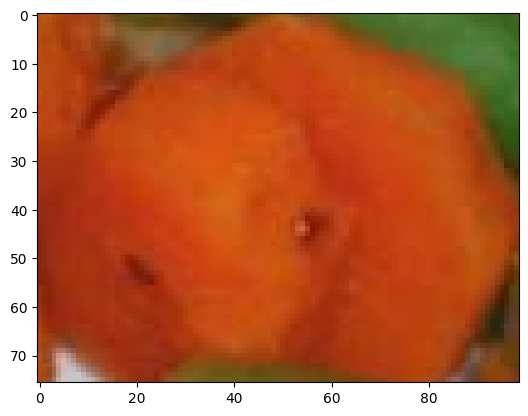

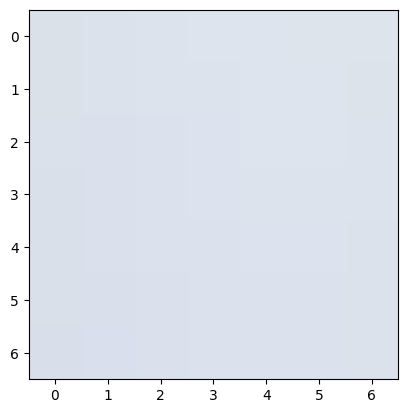

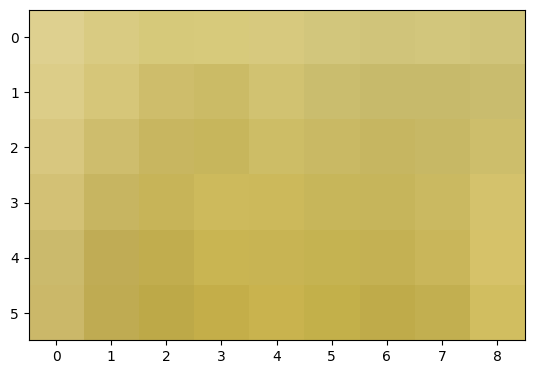

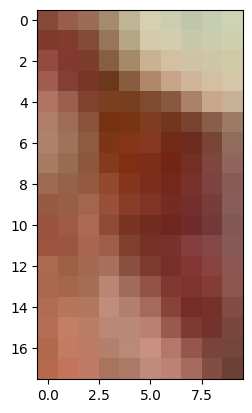

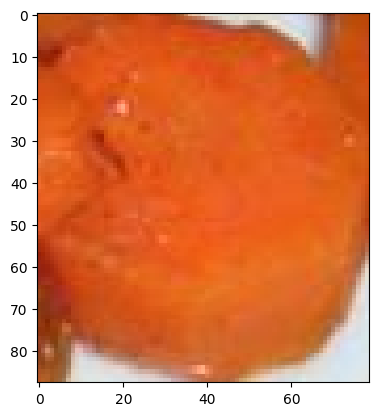

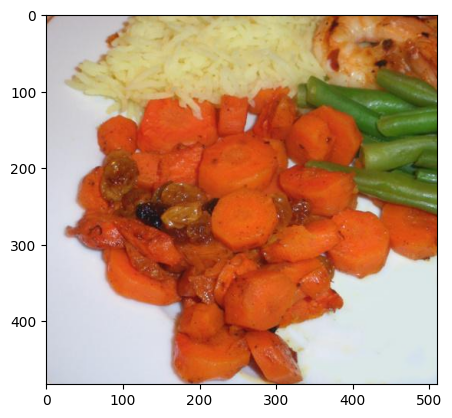

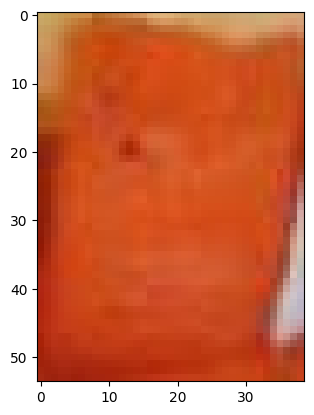

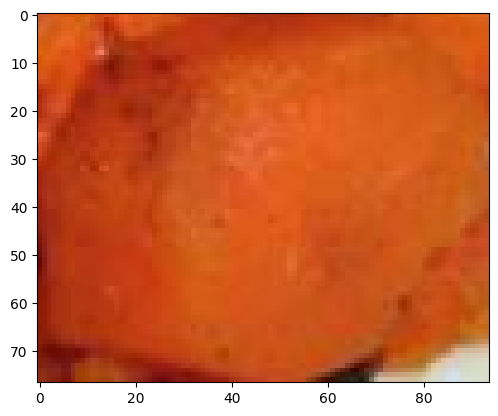

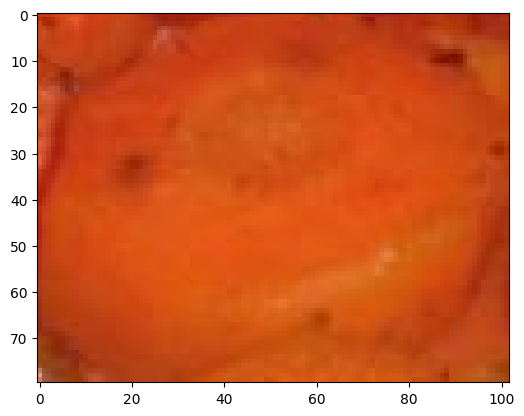

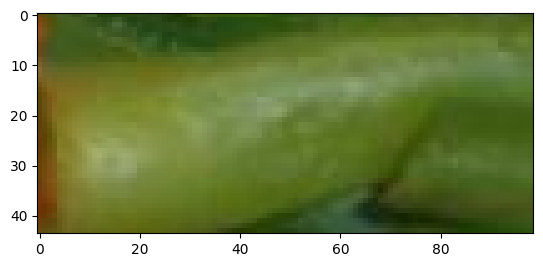

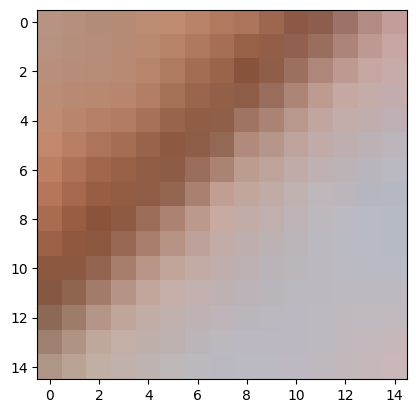

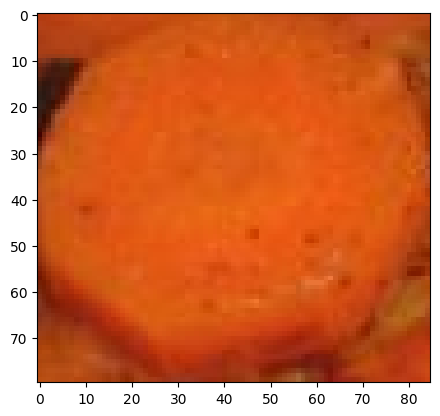

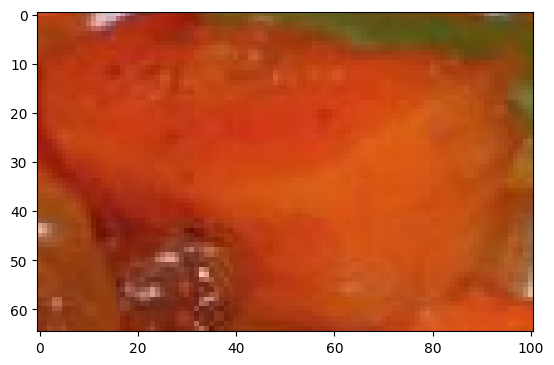

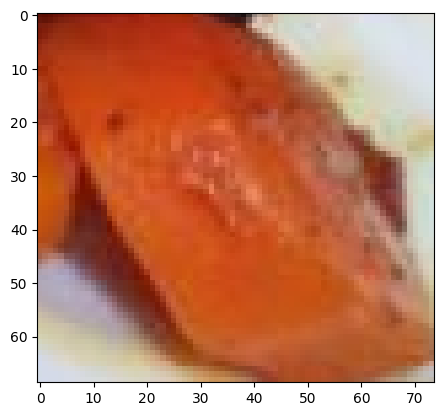

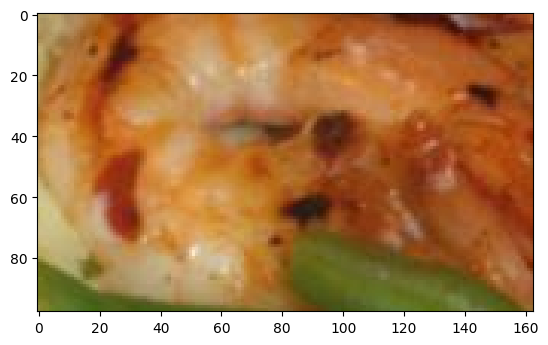

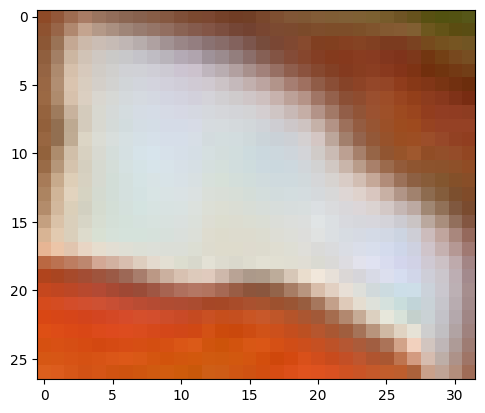

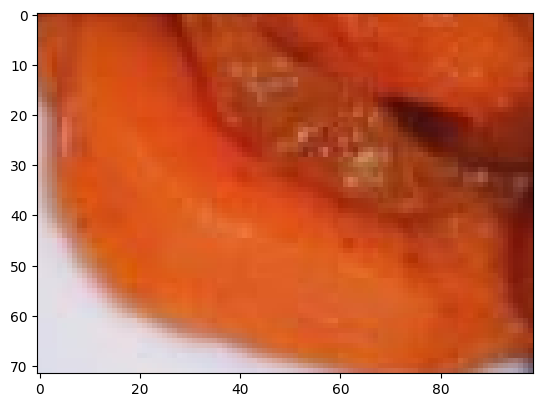

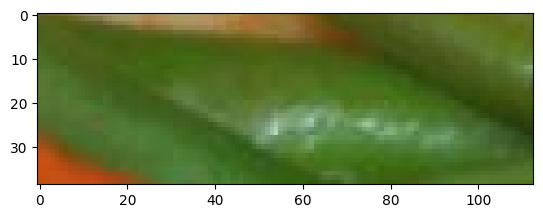

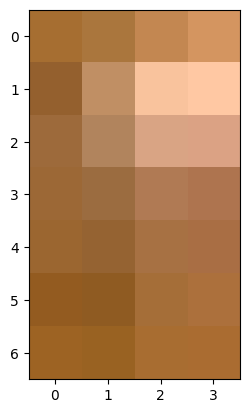

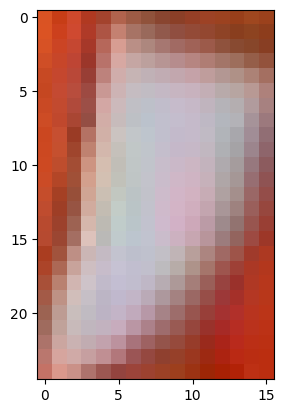

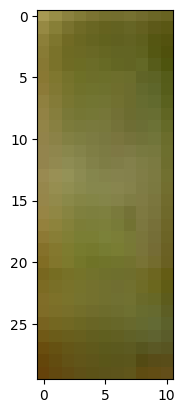

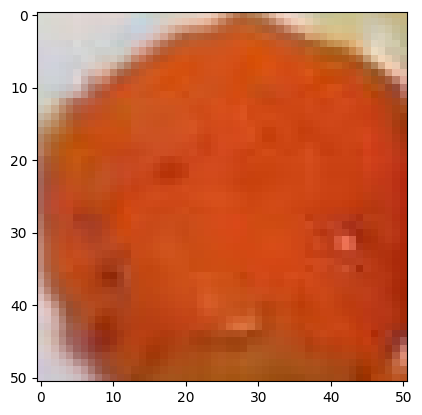

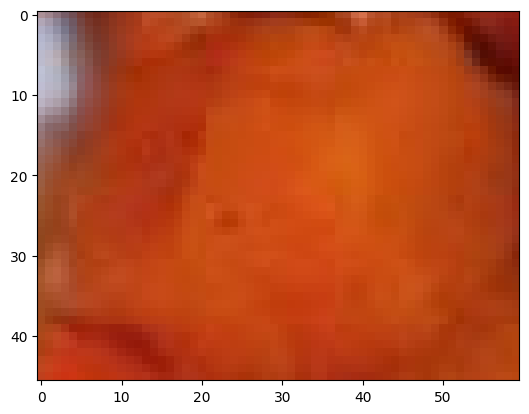

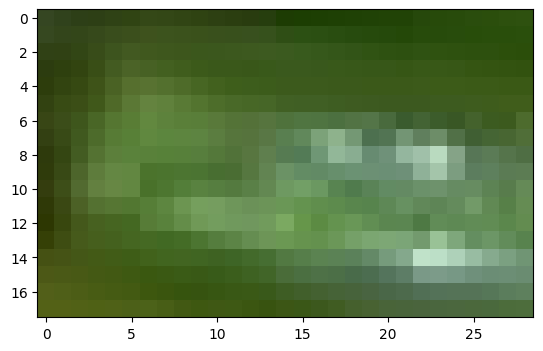

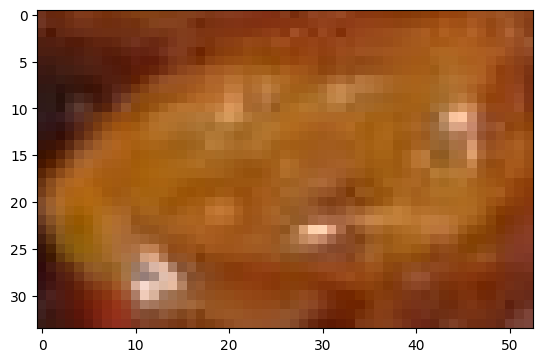

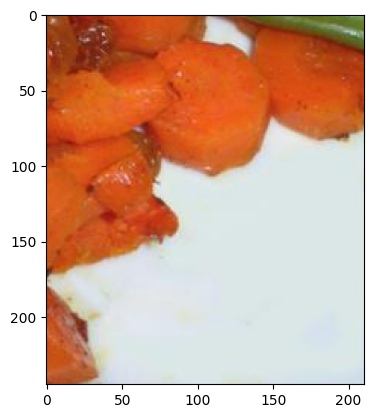

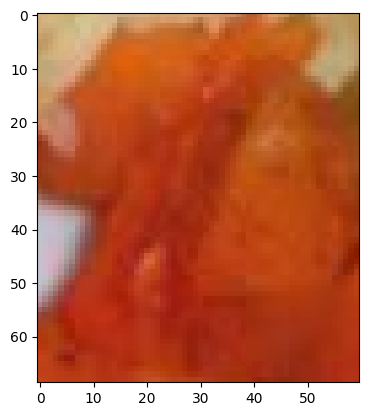

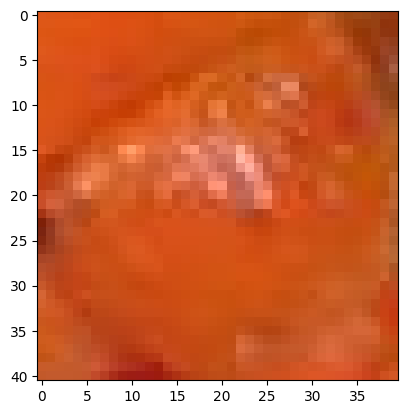

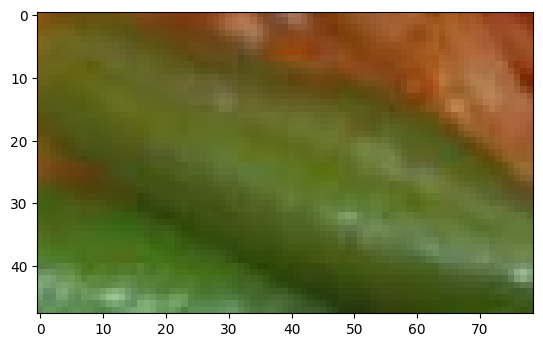

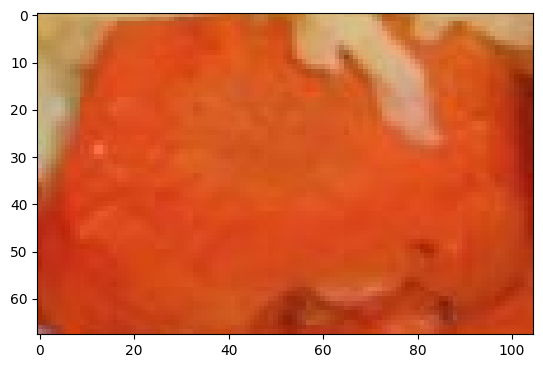

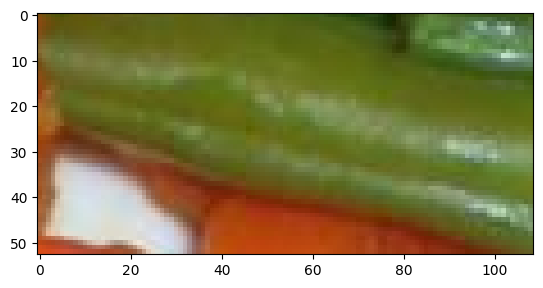

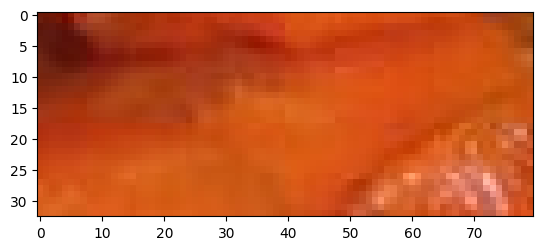

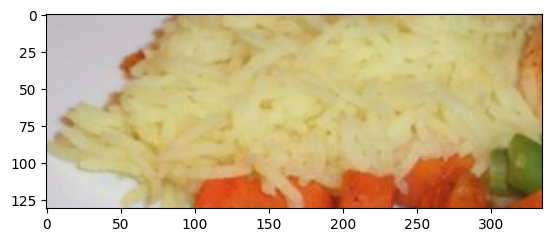

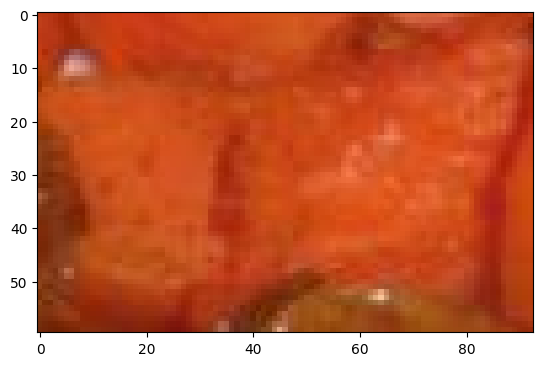

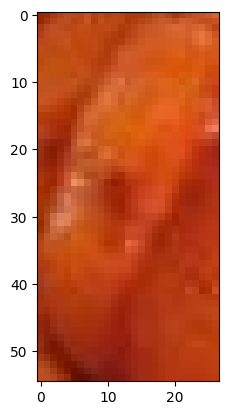

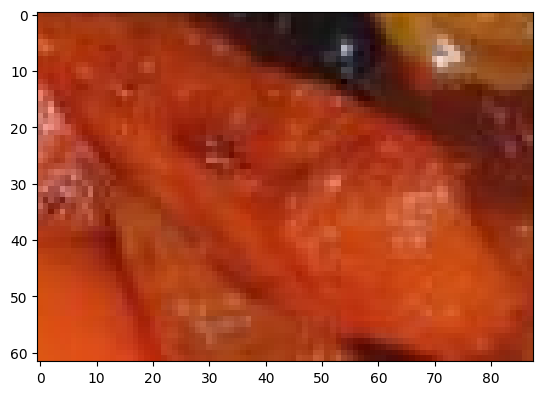

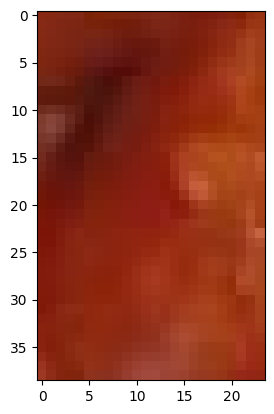

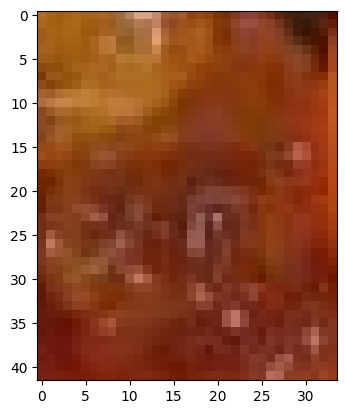

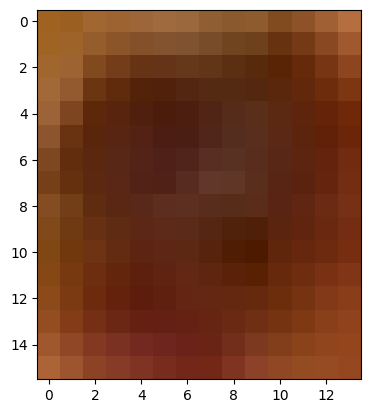

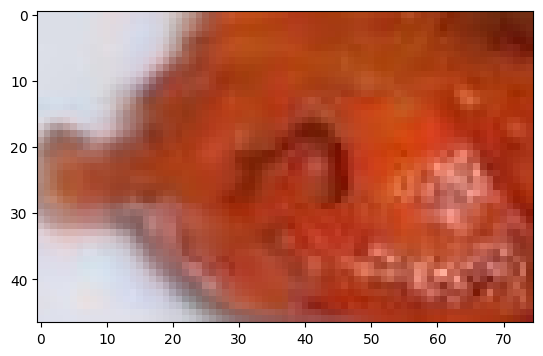

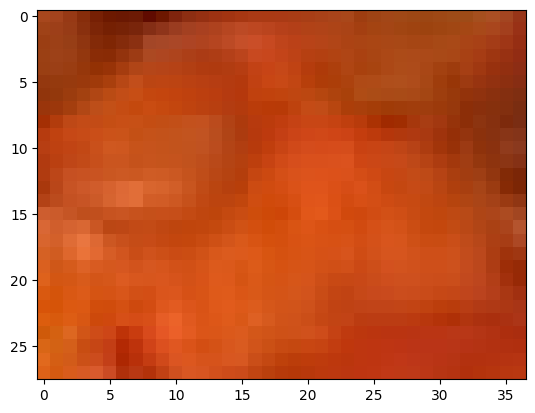

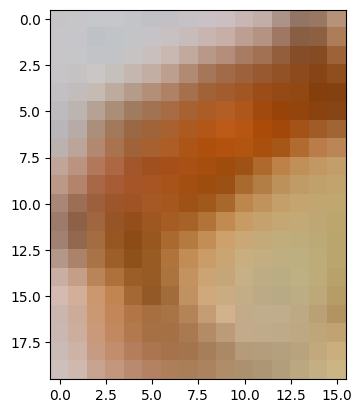

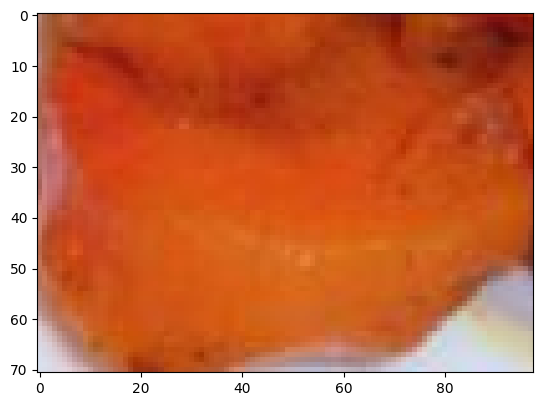

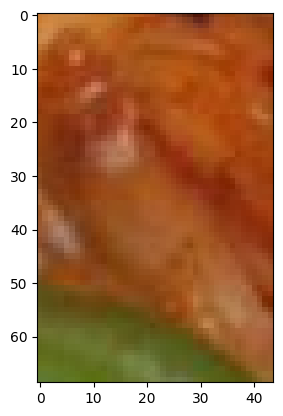

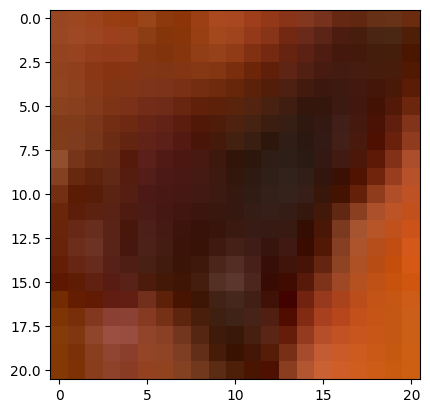

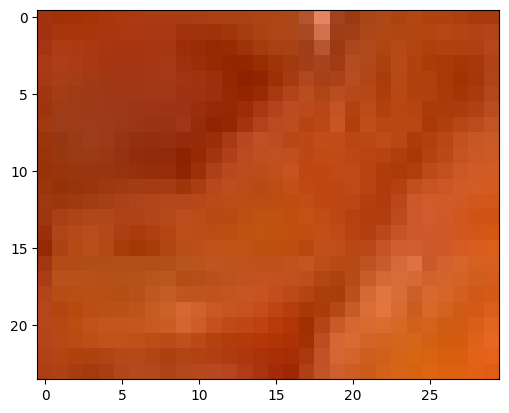

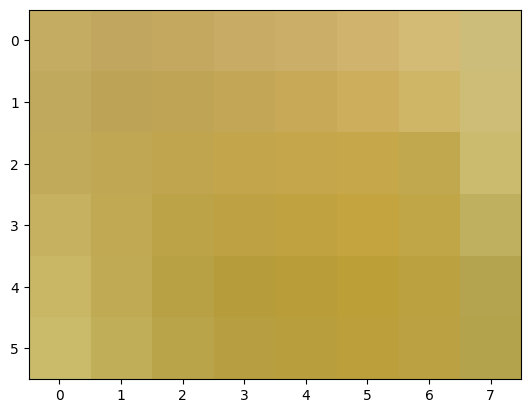

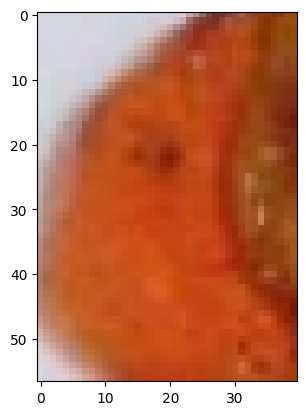

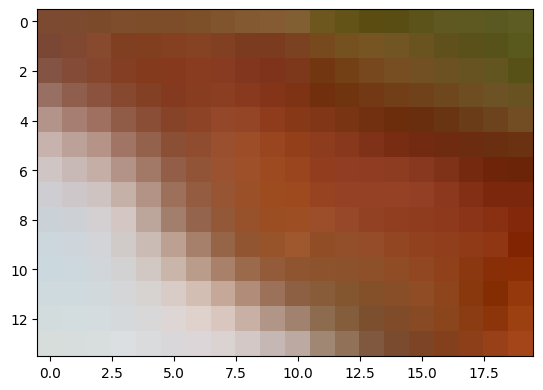

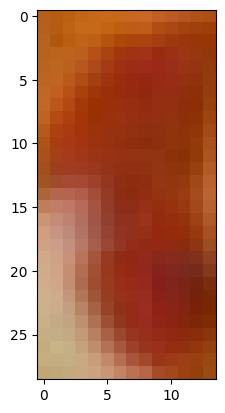

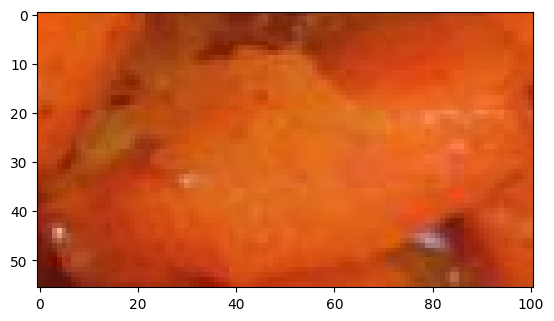

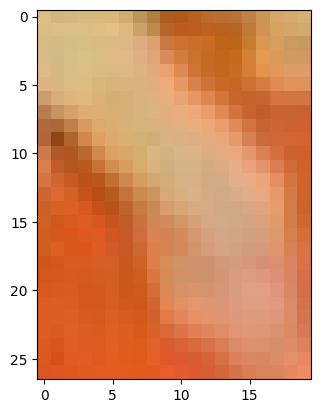

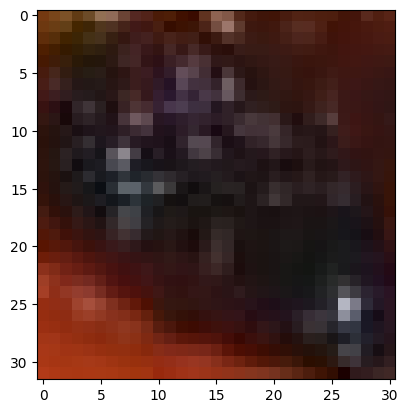

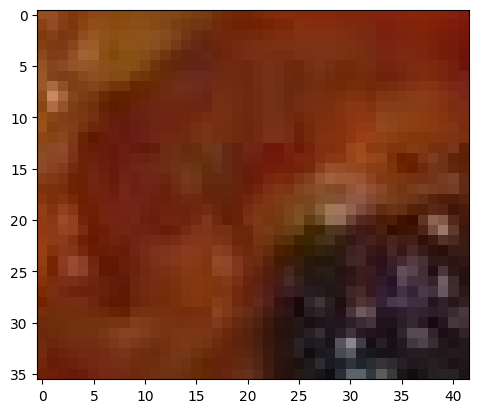

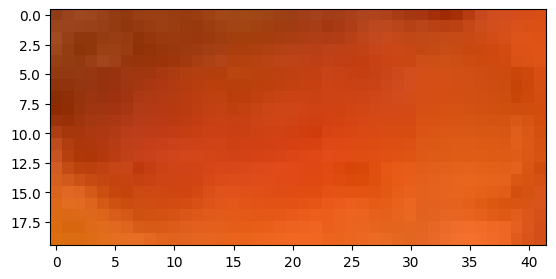

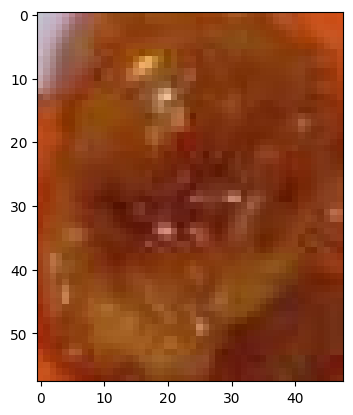

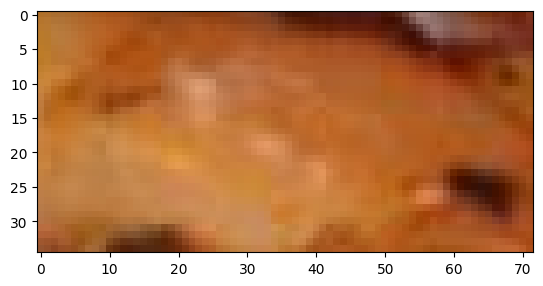

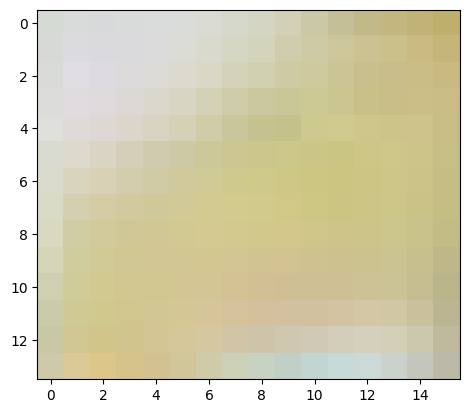

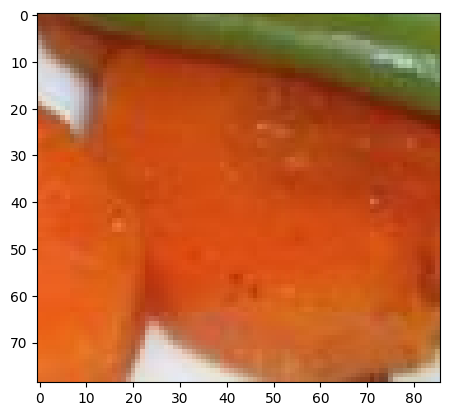

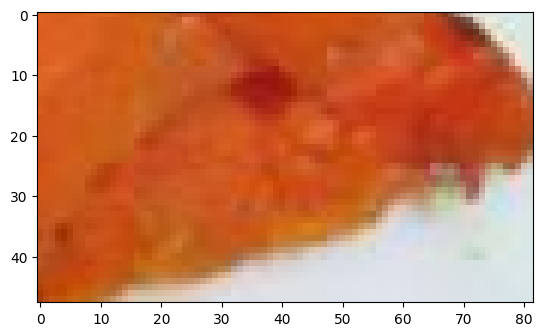

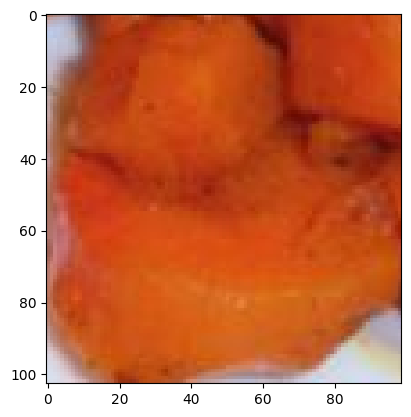

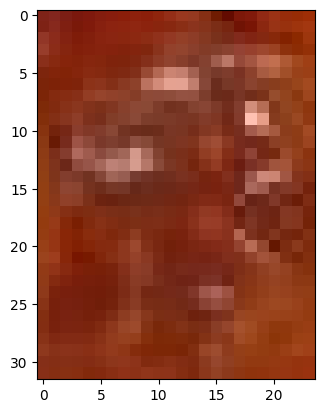

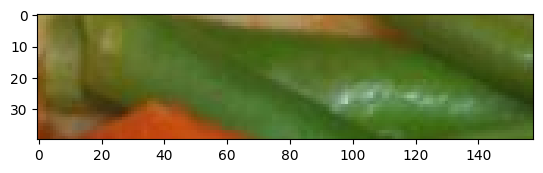

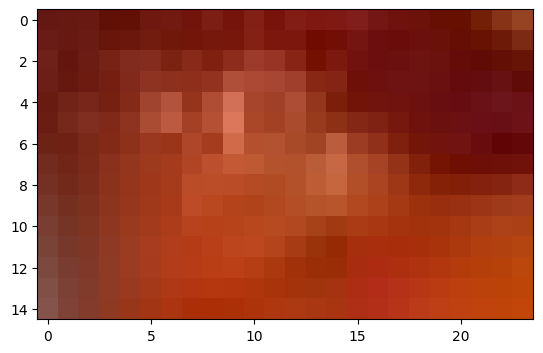

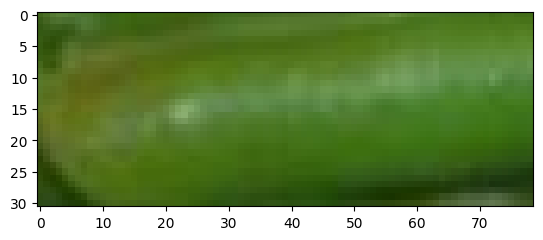

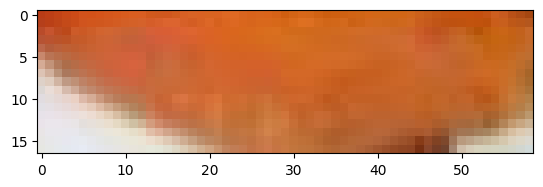

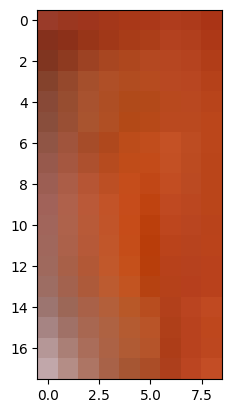

In [40]:
image_bounding_boxes = []
for mask in sorted(masks, key=lambda x: x["stability_score"], reverse=True):
    x0 = mask["bbox"][0]
    y0 = mask["bbox"][1]
    x1 = x0 + mask["bbox"][2]
    y1 = y0 + mask["bbox"][3]
    cropped_image = img[y0:y1, x0:x1, :]
    image_bounding_boxes.append(cropped_image)

for image in image_bounding_boxes:
    plt.imshow(image)
    plt.show()
    plt.close()